In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from func import ShopeeDataset, device, ShopeeNet, torch, np, f1_score_cal, display_df
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors
from efficientnet_pytorch import EfficientNet
import gc
import wandb 

cuda


In [2]:
path = Path.home() / 'OneDrive - Seagroup/computer_vison/shopee_item_images/'
path_img = path / 'train_images'

# input
df = pd.read_csv(path / 'train.csv')

# clean
df['filepath'] = df['image'].map(lambda x: str(path_img / x))
group_dicts = df.groupby('label_group')["posting_id"].unique().to_dict()
df['target'] = df["label_group"].map(group_dicts)

df.head()

,posting_id,image,image_phash,title,label_group,filepath,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3369186413, train_921438619]"


In [3]:
dataset_data = ShopeeDataset(csv=df, train=True)
data_loader = DataLoader(dataset_data, batch_size=16, num_workers=4)

print(f"Dataset Len: {len(dataset_data):,}\nImage Shape [0]: {dataset_data[0][0].shape}")

Dataset Len: 34,250
Image Shape [0]: torch.Size([3, 256, 256])


In [4]:
wandb.init(project='shopee-kaggle', name='image_embeddings')

model_name = 'efficientnet-b3'
model_effnet = EfficientNet.from_name(model_name).to(device)

wandb.log({'Model': model_name})
print(model_name, device)

embeddings = []
with torch.no_grad():
    for image, label in tqdm(data_loader):
        image = image.to(device)
        img_embeddings = model_effnet(image)
        img_embeddings = img_embeddings.detach().cpu().numpy()
        embeddings.append(img_embeddings)
all_image_embeddings = np.concatenate(embeddings)
print(f"image_embeddings shape: {all_image_embeddings.shape[0]:,}/{all_image_embeddings.shape[1]:,}")
torch.save(path / 'tensors.pt', all_image_embeddings)

# Clean memory
del model_effnet
_ = gc.collect()

wandb: Currently logged in as: kevinkhang (use `wandb login --relogin` to force relogin)


efficientnet-b3 cuda


100%|██████████████████████████████████████████████████████████████████████████████| 2141/2141 [02:08<00:00, 16.67it/s]

image_embeddings shape: 34,250/1,000


In [5]:
all_image_embeddings = torch.load(path / 'tensors.pt')

artifact = wandb.Artifact(name='image_embeddings', type='dataset')
artifact.add_file(path / 'tensors.pt')

wandb.log_artifact(artifact)
wandb.log({'Shape of Image embeddings': all_image_embeddings.shape})

In [6]:
wandb.log({"n_neighbors" : 50})

knn_model = NearestNeighbors(n_neighbors=50)
knn_model.fit(all_image_embeddings)

# Creating the splits, to prevent memory errors
predictions = []
CHUNK = 1024 * 4  ### 4096

SPLITS = len(all_image_embeddings) // CHUNK
if len(all_image_embeddings) % CHUNK != 0: SPLITS += 1
print(f'Total Splits: {SPLITS}')

# Making the prediction
print('Finding Similar Images ...')
for no in range(SPLITS):
    a = no * CHUNK
    b = min((no + 1) * CHUNK, len(all_image_embeddings))
    print(f'CHUNK: {a} - {b}')
    
    distances, indices = knn_model.kneighbors(all_image_embeddings[a:b,])
    
    for k in range(b-a):
        index = np.where(distances[k, ] < 6.0)[0]
        split = indices[k, index]
        pred = df.iloc[split]['posting_id'].values.tolist()
        predictions.append(pred)

        
# Clean environment
del knn_model, distances
_ = gc.collect()

Total Splits: 9
Finding Similar Images ...
CHUNK: 0 - 4096
CHUNK: 4096 - 8192
CHUNK: 8192 - 12288
CHUNK: 12288 - 16384
CHUNK: 16384 - 20480
CHUNK: 20480 - 24576
CHUNK: 24576 - 28672
CHUNK: 28672 - 32768
CHUNK: 32768 - 34250


In [8]:
df['img_pred'] = predictions
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,img_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3386243561, train_3423213080]","[train_3386243561, train_2513531713, train_129..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2288590299, train_3803689425]","[train_2288590299, train_3683340044, train_152..."
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2406599165, train_3342059966]","[train_2406599165, train_2893636089, train_163..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3369186413, train_921438619]","[train_3369186413, train_1325593428, train_171..."


In [9]:
df['f1_score'] = [f1_score_cal(i, v) for i, v in df[['target', 'img_pred']].values]
print(f"CV score for baseline = {df['f1_score'].mean():.3f}")

CV score for baseline = 0.114


Text(0, 0.5, '')

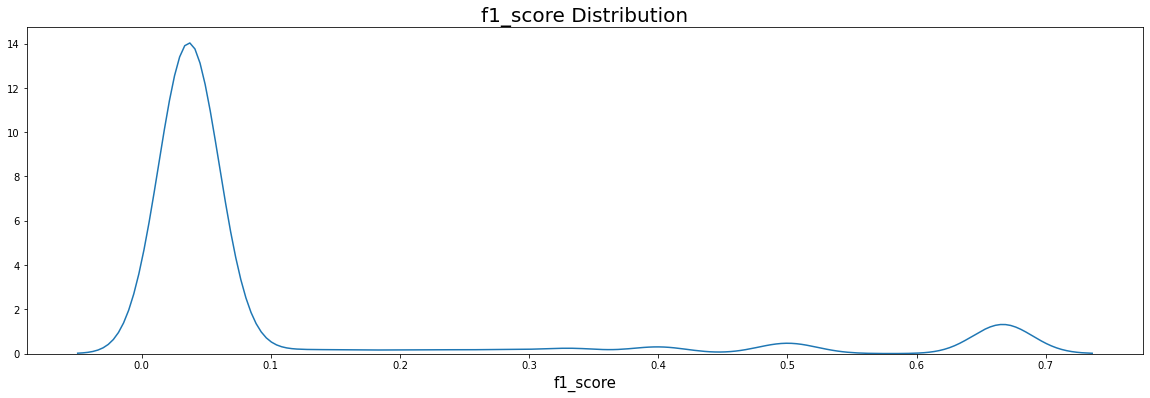

In [10]:
plt.figure(figsize = (20, 6))

plot = sns.kdeplot(x = df["f1_score"])
plt.title("f1_score Distribution", fontsize=20)
plt.xlabel("f1_score", fontsize=15)
plt.ylabel("")

In [11]:
custom_data = [[s] for s in df['f1_score']]
table = wandb.Table(data=custom_data, columns=["f1_score"])
wandb.log({'f1_hist': wandb.plot.histogram(table, "f1_score", title="f1_score Distribution")})
wandb.finish()

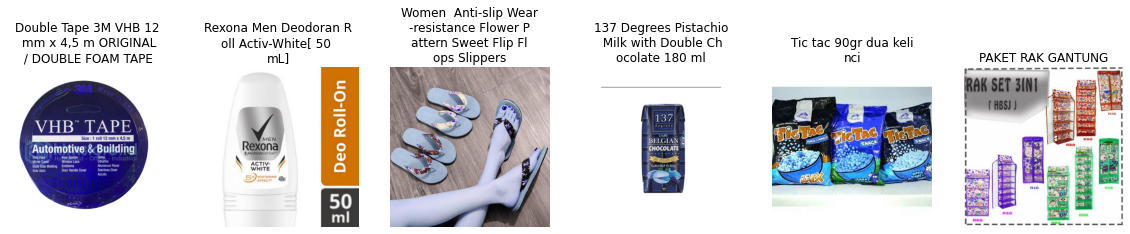

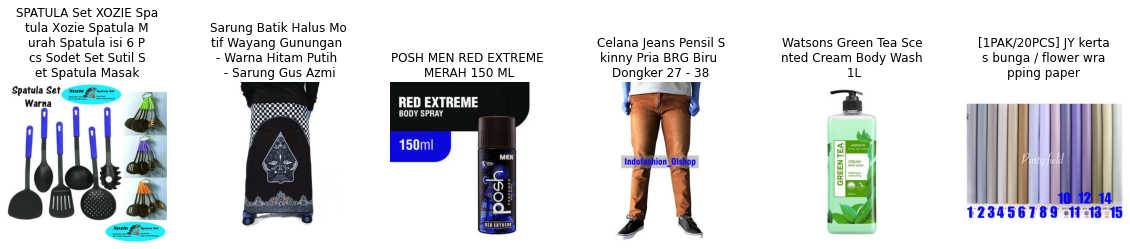

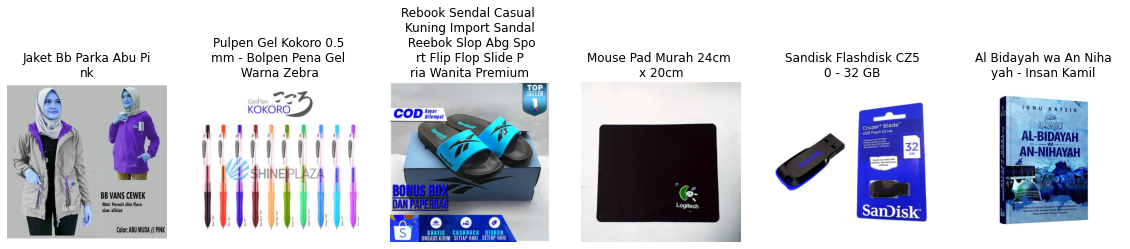

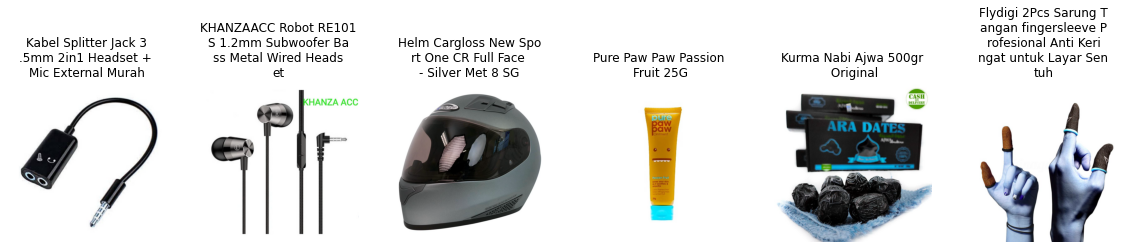

         posting_id                                           filepath  \
0  train_3386243561  C:\Users\PC\OneDrive - Seagroup\computer_vison...   
1  train_2513531713  C:\Users\PC\OneDrive - Seagroup\computer_vison...   
2  train_1291743464  C:\Users\PC\OneDrive - Seagroup\computer_vison...   
3  train_3668859200  C:\Users\PC\OneDrive - Seagroup\computer_vison...   
4  train_1891541718  C:\Users\PC\OneDrive - Seagroup\computer_vison...   

                                               title  
0  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...  
1       Rexona Men Deodoran Roll Activ-White[ 50 mL]  
2  Women  Anti-slip Wear-resistance Flower Patter...  
3  137 Degrees Pistachio Milk with Double Chocola...  
4                           Tic tac 90gr dua kelinci  


In [13]:
test_id = 'train_3386243561'
tmp = pd.DataFrame(df.query(f'posting_id == "{test_id}"')['img_pred'].item(), columns=['posting_id'])
tmp = tmp.merge(df[['posting_id', 'filepath', 'title']], how='left')

display_df(tmp, path_img)
print(tmp.head())